# CS 412 - Machine Learning


# Course Project


# Mahmut Tayyip Çankaya - 24982

Required Imports


In [ ]:
import os
import re
import tqdm
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

from glob import glob
from pathlib import Path
from pprint import pprint
from collections import defaultdict
from bs4 import BeautifulSoup

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn import tree
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, silhouette_score, r2_score, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

from xgboost import XGBRegressor
from nltk.tokenize import word_tokenize
from yellowbrick.cluster import KElbowVisualizer

## Read the html files

Read the html file and store in the format of:
code2convos[html_file_name] = {"role": user or asistant, "text": conversation}

In [ ]:
data_path = "data/html/*.html"

code2convos = dict()

pbar = tqdm.tqdm(sorted(list(glob(data_path))))
for path in pbar:
    # print(Path.cwd() / path)
    file_code = os.path.basename(path).split(".")[0]
    with open(path, "r", encoding="latin1") as fh:

        # get the file id to use it as key later on
        fid = os.path.basename(path).split(".")[0]

        # read the html file
        html_page = fh.read()

        # parse the html file with bs4 so we can extract needed stuff
        soup = BeautifulSoup(html_page, "html.parser")

        # grab the conversations with the data-testid pattern
        data_test_id_pattern = re.compile(r"conversation-turn-[0-9]+")
        conversations = soup.find_all("div", attrs={"data-testid": data_test_id_pattern})

        convo_texts = []

        for i, convo in enumerate(conversations):
            convo = convo.find_all("div", attrs={"data-message-author-role":re.compile( r"[user|assistant]") })
            if len(convo) > 0:
                role = convo[0].get("data-message-author-role")
                convo_texts.append({
                        "role" : role,
                        "text" : convo[0].text
                    }
                )

        code2convos[file_code] = convo_texts

100%|██████████| 127/127 [00:13<00:00,  9.33it/s]


In [ ]:
# let's see one of the conversations
pprint(code2convos["0031c86e-81f4-4eef-9e0e-28037abf9883"])

[{'role': 'user',
  'text': 'Load a CSV file into a Pandas in Python. The file is named '
          "'cs412_hw1_dataset.csv' and contains columns like 'Species', "
          "'Island', 'Sex', 'Diet', 'Year', 'Life Stage', 'Body Mass (g)', "
          "'Bill Length (mm)', 'Bill Depth (mm)', 'Flipper Length (mm)', and "
          "'Health Metrics'. \n"},
 {'role': 'assistant',
  'text': 'You can load a CSV file into a Pandas DataFrame in Python using the '
          "pandas.read_csv() function. Here's how you can do it for your "
          'specific CSV file:pythonCopy codeimport pandas as pd\n'
          '\n'
          '# Specify the file path\n'
          "file_path = 'cs412_hw1_dataset.csv'\n"
          '\n'
          '# Load the CSV file into a Pandas DataFrame\n'
          'df = pd.read_csv(file_path)\n'
          '\n'
          '# Display the first few rows of the DataFrame to verify the data '
          'has been loaded\n'
          'print(df.head())\n'
          "This code assume

#### Things to do:
- Prompt matching with questions
- Feature Engineering
- Question Grades preparation
- Train/Test split
- Fitting a model for predicting the scores

#### Prompt Matching
> We want to match the prompts with the questions in the Homework Let's
> do it with a simple term frequency vectorizing method. For each prompt,
> we will come with a vector that represents it. We will do the same
> thing with each of the homework questions. Then, we will calculate the
> vectors distanance to do the matching

In [ ]:
prompts = []
code2prompts = defaultdict(list)
for code , convos in code2convos.items():
    user_prompts = []
    for conv in convos:
        if conv["role"] == "user":
            prompts.append(conv["text"])
            user_prompts.append(conv["text"])
    code2prompts[code] = user_prompts

In [ ]:
prompts[0]

"Load a CSV file into a Pandas in Python. The file is named 'cs412_hw1_dataset.csv' and contains columns like 'Species', 'Island', 'Sex', 'Diet', 'Year', 'Life Stage', 'Body Mass (g)', 'Bill Length (mm)', 'Bill Depth (mm)', 'Flipper Length (mm)', and 'Health Metrics'. \n"

In [ ]:
questions = [
    """Initialize
*   First make a copy of the notebook given to you as a starter.
*   Make sure you choose Connect form upper right.
*   You may upload the data to the section on your left on Colab, than right click on the .csv file and get the path of the file by clicking on "Copy Path". You will be using it when loading the data.

""",
#####################
    """Load training dataset (5 pts)
    *  Read the .csv file with the pandas library
""",
#####################
"""Understanding the dataset & Preprocessing (15 pts)
Understanding the Dataset: (5 pts)
> - Find the shape of the dataset (number of samples & number of attributes). (Hint: You can use the **shape** function)
> - Display variable names (both dependent and independent).
> - Display the summary of the dataset. (Hint: You can use the **info** function)
> - Display the first 5 rows from training dataset. (Hint: You can use the **head** function)
Preprocessing: (10 pts)

> - Check if there are any missing values in the dataset. If there are, you can either drop these values or fill it with most common values in corresponding rows. **Be careful that you have enough data for training the  model.**

> - Encode categorical labels with the mappings given in the cell below. (Hint: You can use **map** function)
""",
"""Set X & y, split data (5 pts)

*   Shuffle the dataset.
*   Seperate your dependent variable X, and your independent variable y. The column health_metrics is y, the rest is X.
*   Split training and test sets as 80% and 20%, respectively.
""",
#####################
"""Features and Correlations (10 pts)

* Correlations of features with health (4 points)
Calculate the correlations for all features in dataset. Highlight any strong correlations with the target variable. Plot your results in a heatmap.

* Feature Selection (3 points)
Select a subset of features that are likely strong predictors, justifying your choices based on the computed correlations.

* Hypothetical Driver Features (3 points)
Propose two hypothetical features that could enhance the model's predictive accuracy for Y, explaining how they might be derived and their expected impact. Show the resulting correlations with target variable.

* __Note:__ You get can get help from GPT.
""",
#####################
"""Tune Hyperparameters (20 pts)
* Choose 2 hyperparameters to tune. You can use the Scikit learn decision tree documentation for the available hyperparameters *(Hyperparameters are listed under "Parameters" in the documentation)*. Use GridSearchCV for hyperparameter tuning, with a cross-validation value of 5. Use validation accuracy to pick the best hyper-parameter values. (15 pts)
-Explain the hyperparameters you chose to tune. *(What are the hyperparameters you chose? Why did you choose them?)* (5 pts)
""",
#####################
"""Re-train and plot the decision tree with the hyperparameters you have chosen (15 pts)
- Re-train model with the hyperparameters you have chosen in part 5). (10 pts)
- Plot the tree you have trained. (5 pts)
Hint: You can import the **plot_tree** function from the sklearn library.
""",
#####################
"""Test your classifier on the test set (20 pts)
- Predict the labels of testing data using the tree you have trained in step 6. (10 pts)
- Report the classification accuracy. (2 pts)
- Plot & investigate the confusion matrix. Fill the following blanks. (8 pts)
> The model most frequently mistakes class(es) _________ for class(es) _________.
Hint: You can use the confusion_matrix function from sklearn.metrics
""",
#####################
"""Find the information gain on the first split (10 pts)""",
#####################
]

In [ ]:
def custom_preprocessor(text):
    text = re.sub(r"[^a-zA-ZğüşıöçĞÜŞİÖÇ\s]", "", text)
    text = re.sub(r"\s+", " ", text).strip()
    text = text.lower()
    return text

vectorizer = TfidfVectorizer(
    max_features=1000,
    stop_words='english',
    ngram_range=(1,2),
    preprocessor=custom_preprocessor,
)
vectorizer = vectorizer.fit(prompts + questions)

In [ ]:
questions_TF_IDF = pd.DataFrame(vectorizer.transform(questions).toarray(), columns=vectorizer.get_feature_names_out())
questions_TF_IDF.head()

,according,according formula,accordingly,accuracy,accuracy explaining,accuracy pick,accuracy pts,accuracyscore,accuracyscore sklearnmodelselection,accuracyscoreytest,...,year data,year dtype,year year,ypred,ytest,ytest traintestsplitx,ytrain,ytrain best,ytrain fitparams,ytrain ytest
0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.059211,0.081895,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
code2prompts_tf_idf = dict()
for code, user_prompts in code2prompts.items():
    if len(user_prompts) == 0:
        # some files have issues
        print(code+".html")
        continue
    prompts_TF_IDF = pd.DataFrame(vectorizer.transform(user_prompts).toarray(), columns=vectorizer.get_feature_names_out())
    code2prompts_tf_idf[code] = prompts_TF_IDF

139235c7-736c-4237-92f0-92e8c116832c.html
668ad17e-0240-49f7-b5a7-d22e502554c6.html
b0640e51-6879-40cb-a4f5-329f952ef99d.html
da6b70d5-29f6-491a-ad46-037c77067128.html


In [ ]:
code2prompts_tf_idf["089eb66d-4c3a-4f58-b98f-a3774a2efb34"].shape

(86, 1000)

In [ ]:
code2cosine = dict()
for code, user_prompts_tf_idf in code2prompts_tf_idf.items():
    code2cosine[code] = pd.DataFrame(cosine_similarity(questions_TF_IDF,user_prompts_tf_idf))

Calculate the cosine similarity between prompts and questions

In [ ]:
code2questionmapping = dict()
for code, cosine_scores in code2cosine.items():
    code2questionmapping[code] = code2cosine[code].max(axis=1).tolist()


question_mapping_scores = pd.DataFrame(code2questionmapping).T
question_mapping_scores.reset_index(inplace=True)
question_mapping_scores.rename(columns={i: f"Q_{i}" for i in range(len(questions))}, inplace=True)
question_mapping_scores.rename(columns={"index" : "code"}, inplace=True)

question_mapping_scores

,code,Q_0,Q_1,Q_2,Q_3,Q_4,Q_5,Q_6,Q_7,Q_8
0,0031c86e-81f4-4eef-9e0e-28037abf9883,0.121669,0.240754,0.406415,0.344203,0.442081,0.501032,0.105125,0.082355,0.041075
1,0225686d-b825-4cac-8691-3a3a5343df2b,0.210707,0.772151,0.740568,0.811677,0.572309,0.973505,0.770091,0.610085,0.463622
2,041f950b-c013-409a-a642-cffff60b9d4b,0.085978,0.205666,0.465918,0.270713,0.631067,0.348896,0.350870,0.415376,0.190334
3,04f91058-d0f8-4324-83b2-19c671f433dc,0.050142,0.096359,0.164982,0.215613,0.385329,0.288037,0.088504,0.223102,0.376481
4,089eb66d-4c3a-4f58-b98f-a3774a2efb34,0.485869,0.679591,0.762361,0.576194,0.676059,0.831945,0.593740,0.919089,0.393665
...,...,...,...,...,...,...,...,...,...,...
118,f24219d6-07f0-4baf-80ac-18475dc5b66f,0.175684,0.136040,0.147575,0.142843,0.135665,0.453396,1.000000,0.985977,0.695163
119,f2f18684-4a16-4c05-a2d1-c0f96d1de869,0.123174,0.071579,0.220588,0.878117,0.745706,0.857940,0.216946,0.911933,0.584470
120,f852596d-fdca-45aa-9050-d4f76ce6a53c,0.172459,0.943401,0.959244,0.945942,0.902319,0.944276,0.778231,0.867032,0.443759
121,f8ec3336-fd48-4654-ad98-62ccfb96d096,0.172459,0.943401,1.000000,0.689305,0.984198,0.880480,1.000000,1.000000,0.698401


# Feature Engineering
- Number of prompts that a uers asked
- Number of complaints that a user makes e.g "the code gives this error!"
- User prompts average number of characters

Features:
* number of user prompts
* user prompts average number of words
* user prompts average number of sentence length
* user prompts average number of characters
* response average number of words
* response average number of sentence length
* response average number of characters
* number of keywords: "error", "fix", "no", "thank"

In [ ]:
code2features = defaultdict(lambda : defaultdict(int))

keywords2search = ["error", "fix", "no", "thank"]
keywords2search = [k.lower() for k in keywords2search]

for code, convs in code2convos.items():
    if len(convs) == 0:
        print(code)
        continue
    for c in convs:
        text = c["text"].lower()
        words = text.split()
        sentences = text.split('.')
        num_words = len(words)
        num_sentences = len(sentences)
        avg_sentence_length = num_words / num_sentences if num_sentences > 0 else 0

        if c["role"] == "user":
            # User Prompts

            # count the user prompts
            code2features[code]["#user_prompts"] += 1
            code2features[code]["prompt_avg_words"] += num_words
            code2features[code]["prompt_avg_sentence_length"] += avg_sentence_length
            code2features[code]["prompt_avg_chars"] += len(text)

            # count the keywords
            for kw in keywords2search:
                code2features[code][f"#{kw}"] +=  len(re.findall(rf"\b{kw}\b", text))

            code2features[code]["prompt_avg_chars"] += len(text)
        else:
            # ChatGPT Responses
            code2features[code]["response_avg_chars"] += len(text)
            code2features[code]["response_avg_words"] += num_words
            code2features[code]["response_avg_sentence_length"] += avg_sentence_length


        code2features[code]["prompt_avg_chars"] /= code2features[code]["#user_prompts"]
        code2features[code]["response_avg_chars"] /= code2features[code]["#user_prompts"]
        code2features[code]["prompt_avg_words"] /= code2features[code]["#user_prompts"]
        code2features[code]["prompt_avg_sentence_length"] /= code2features[code]["#user_prompts"]
        code2features[code]["response_avg_words"] /= code2features[code]["#user_prompts"]
        code2features[code]["response_avg_sentence_length"] /= code2features[code]["#user_prompts"]

139235c7-736c-4237-92f0-92e8c116832c
668ad17e-0240-49f7-b5a7-d22e502554c6
b0640e51-6879-40cb-a4f5-329f952ef99d
da6b70d5-29f6-491a-ad46-037c77067128


In [ ]:
df = pd.DataFrame(code2features).T
df.head(5)

,#user_prompts,prompt_avg_words,prompt_avg_sentence_length,prompt_avg_chars,#error,#fix,#no,#thank,response_avg_chars,response_avg_words,response_avg_sentence_length
0031c86e-81f4-4eef-9e0e-28037abf9883,14.0,0.322617,0.064877,4.411497,3.0,0.0,1.0,0.0,212.206370,26.255108,1.010375
0225686d-b825-4cac-8691-3a3a5343df2b,18.0,0.055791,0.055791,0.608325,0.0,0.0,0.0,0.0,113.633582,16.578947,1.384857
041f950b-c013-409a-a642-cffff60b9d4b,9.0,0.053652,0.053652,0.524648,3.0,0.0,0.0,1.0,17.187601,3.065649,1.369713
04f91058-d0f8-4324-83b2-19c671f433dc,20.0,0.017632,0.005965,0.246691,1.0,0.0,1.0,0.0,107.092566,13.347445,0.494491
089eb66d-4c3a-4f58-b98f-a3774a2efb34,86.0,0.003110,0.003110,0.035971,1.0,2.0,5.0,0.0,18.850913,2.697958,0.224842


## Read scores data

In [ ]:
# reading the scores
scores = pd.read_csv("data/scores.csv", sep=",")
scores["code"] = scores["code"].apply(lambda x: x.strip())

# selecting the columns we need and we care
scores = scores[["code", "grade"]]

# show some examples
scores.head()

,code,grade
0,6a2003ad-a05a-41c9-9d48-e98491a90499,90.0
1,04f91058-d0f8-4324-83b2-19c671f433dc,97.0
2,81fdeb2a-e7e5-4a05-8058-d31ea579b0d9,94.0
3,6a903495-c5be-4263-b4dd-75e2bbc30434,97.0
4,6d5742c1-77c4-429c-8f6e-ef1262ca5557,93.0


## Plot the distribution of grades

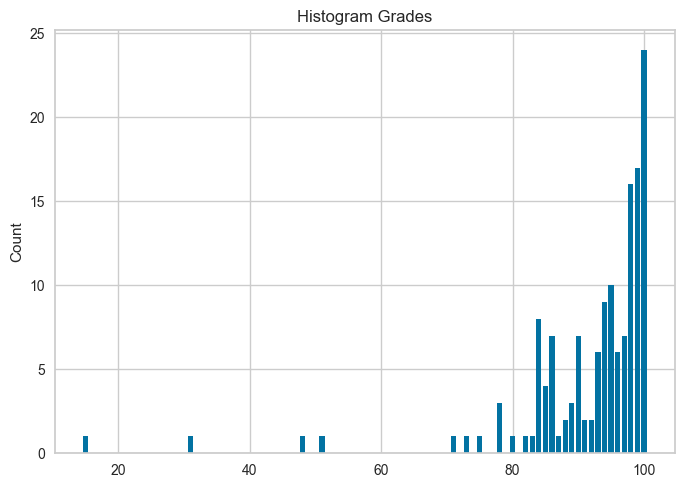

In [ ]:
# Let's check grades distribution

plt.title('Histogram Grades')
plt.hist(scores["grade"], rwidth=.8, bins=np.arange(min(scores["grade"]), max(scores["grade"])+2) - 0.5)
plt.ylabel('Count')
plt.show()

In [ ]:
df.reset_index(inplace=True, drop=False)
df.rename(columns={"index": "code"}, inplace=True)
df.head()

,code,#user_prompts,prompt_avg_words,prompt_avg_sentence_length,prompt_avg_chars,#error,#fix,#no,#thank,response_avg_chars,response_avg_words,response_avg_sentence_length
0,0031c86e-81f4-4eef-9e0e-28037abf9883,14.0,0.322617,0.064877,4.411497,3.0,0.0,1.0,0.0,212.206370,26.255108,1.010375
1,0225686d-b825-4cac-8691-3a3a5343df2b,18.0,0.055791,0.055791,0.608325,0.0,0.0,0.0,0.0,113.633582,16.578947,1.384857
2,041f950b-c013-409a-a642-cffff60b9d4b,9.0,0.053652,0.053652,0.524648,3.0,0.0,0.0,1.0,17.187601,3.065649,1.369713
3,04f91058-d0f8-4324-83b2-19c671f433dc,20.0,0.017632,0.005965,0.246691,1.0,0.0,1.0,0.0,107.092566,13.347445,0.494491
4,089eb66d-4c3a-4f58-b98f-a3774a2efb34,86.0,0.003110,0.003110,0.035971,1.0,2.0,5.0,0.0,18.850913,2.697958,0.224842


Create features df

In [ ]:
df = pd.merge(df, question_mapping_scores, on="code", how="left")
df.head()

,code,#user_prompts,prompt_avg_words,prompt_avg_sentence_length,prompt_avg_chars,#error,#fix,#no,#thank,response_avg_chars,...,response_avg_sentence_length,Q_0,Q_1,Q_2,Q_3,Q_4,Q_5,Q_6,Q_7,Q_8
0,0031c86e-81f4-4eef-9e0e-28037abf9883,14.0,0.322617,0.064877,4.411497,3.0,0.0,1.0,0.0,212.206370,...,1.010375,0.121669,0.240754,0.406415,0.344203,0.442081,0.501032,0.105125,0.082355,0.041075
1,0225686d-b825-4cac-8691-3a3a5343df2b,18.0,0.055791,0.055791,0.608325,0.0,0.0,0.0,0.0,113.633582,...,1.384857,0.210707,0.772151,0.740568,0.811677,0.572309,0.973505,0.770091,0.610085,0.463622
2,041f950b-c013-409a-a642-cffff60b9d4b,9.0,0.053652,0.053652,0.524648,3.0,0.0,0.0,1.0,17.187601,...,1.369713,0.085978,0.205666,0.465918,0.270713,0.631067,0.348896,0.350870,0.415376,0.190334
3,04f91058-d0f8-4324-83b2-19c671f433dc,20.0,0.017632,0.005965,0.246691,1.0,0.0,1.0,0.0,107.092566,...,0.494491,0.050142,0.096359,0.164982,0.215613,0.385329,0.288037,0.088504,0.223102,0.376481
4,089eb66d-4c3a-4f58-b98f-a3774a2efb34,86.0,0.003110,0.003110,0.035971,1.0,2.0,5.0,0.0,18.850913,...,0.224842,0.485869,0.679591,0.762361,0.576194,0.676059,0.831945,0.593740,0.919089,0.393665


In [ ]:
df.shape

(123, 21)

#### Merging scores with features

In [ ]:
full_df = pd.merge(df, scores, on='code', how="left")
full_df.dropna(inplace=True)
full_df.drop_duplicates("code",inplace=True, keep="first")
full_df.head()

,code,#user_prompts,prompt_avg_words,prompt_avg_sentence_length,prompt_avg_chars,#error,#fix,#no,#thank,response_avg_chars,...,Q_0,Q_1,Q_2,Q_3,Q_4,Q_5,Q_6,Q_7,Q_8,grade
0,0031c86e-81f4-4eef-9e0e-28037abf9883,14.0,0.322617,0.064877,4.411497,3.0,0.0,1.0,0.0,212.206370,...,0.121669,0.240754,0.406415,0.344203,0.442081,0.501032,0.105125,0.082355,0.041075,48.0
1,0225686d-b825-4cac-8691-3a3a5343df2b,18.0,0.055791,0.055791,0.608325,0.0,0.0,0.0,0.0,113.633582,...,0.210707,0.772151,0.740568,0.811677,0.572309,0.973505,0.770091,0.610085,0.463622,99.0
2,041f950b-c013-409a-a642-cffff60b9d4b,9.0,0.053652,0.053652,0.524648,3.0,0.0,0.0,1.0,17.187601,...,0.085978,0.205666,0.465918,0.270713,0.631067,0.348896,0.350870,0.415376,0.190334,90.0
3,04f91058-d0f8-4324-83b2-19c671f433dc,20.0,0.017632,0.005965,0.246691,1.0,0.0,1.0,0.0,107.092566,...,0.050142,0.096359,0.164982,0.215613,0.385329,0.288037,0.088504,0.223102,0.376481,97.0
4,089eb66d-4c3a-4f58-b98f-a3774a2efb34,86.0,0.003110,0.003110,0.035971,1.0,2.0,5.0,0.0,18.850913,...,0.485869,0.679591,0.762361,0.576194,0.676059,0.831945,0.593740,0.919089,0.393665,100.0


#### Train Test Data Split

In [ ]:
features_labels_data = full_df.copy()[full_df.columns[1:]]
features_labels_data.head()

,#user_prompts,prompt_avg_words,prompt_avg_sentence_length,prompt_avg_chars,#error,#fix,#no,#thank,response_avg_chars,response_avg_words,...,Q_0,Q_1,Q_2,Q_3,Q_4,Q_5,Q_6,Q_7,Q_8,grade
0,14.0,0.322617,0.064877,4.411497,3.0,0.0,1.0,0.0,212.206370,26.255108,...,0.121669,0.240754,0.406415,0.344203,0.442081,0.501032,0.105125,0.082355,0.041075,48.0
1,18.0,0.055791,0.055791,0.608325,0.0,0.0,0.0,0.0,113.633582,16.578947,...,0.210707,0.772151,0.740568,0.811677,0.572309,0.973505,0.770091,0.610085,0.463622,99.0
2,9.0,0.053652,0.053652,0.524648,3.0,0.0,0.0,1.0,17.187601,3.065649,...,0.085978,0.205666,0.465918,0.270713,0.631067,0.348896,0.350870,0.415376,0.190334,90.0
3,20.0,0.017632,0.005965,0.246691,1.0,0.0,1.0,0.0,107.092566,13.347445,...,0.050142,0.096359,0.164982,0.215613,0.385329,0.288037,0.088504,0.223102,0.376481,97.0
4,86.0,0.003110,0.003110,0.035971,1.0,2.0,5.0,0.0,18.850913,2.697958,...,0.485869,0.679591,0.762361,0.576194,0.676059,0.831945,0.593740,0.919089,0.393665,100.0


In [ ]:
X = features_labels_data.drop(columns=["grade"])
y = features_labels_data["grade"]

In [ ]:
print(X.head())
print(y.head())

   #user_prompts  prompt_avg_words  prompt_avg_sentence_length  \
0           14.0          0.322617                    0.064877   
1           18.0          0.055791                    0.055791   
2            9.0          0.053652                    0.053652   
3           20.0          0.017632                    0.005965   
4           86.0          0.003110                    0.003110   

   prompt_avg_chars  #error  #fix  #no  #thank  response_avg_chars  \
0          4.411497     3.0   0.0  1.0     0.0          212.206370   
1          0.608325     0.0   0.0  0.0     0.0          113.633582   
2          0.524648     3.0   0.0  0.0     1.0           17.187601   
3          0.246691     1.0   0.0  1.0     0.0          107.092566   
4          0.035971     1.0   2.0  5.0     0.0           18.850913   

   response_avg_words  response_avg_sentence_length       Q_0       Q_1  \
0           26.255108                      1.010375  0.121669  0.240754   
1           16.578947           

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("Train set size:", len(X_train))
print("Test set size:", len(X_test))

Train set size: 97
Test set size: 25


In [ ]:
X_train_2, X_val, y_train_2, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
print("Train set size:", len(X_train_2))
print("Validation set size:", len(X_val))

Train set size: 77
Validation set size: 20


## Modelling

### DecisionTreeRegressor with calculated weights

In [ ]:
def calculate_weights(y):
    weights = np.where((y >= 80) & (y <= 100), 1.5, 1.0)
    return weights

weights = calculate_weights(y_train)

#### Fitting a model with GridSearch

In [ ]:
param_grid = {
    'max_depth': [10, 20, 30, 40, 50, None],
    'min_samples_split': [2, 5, 10, 20, 40],
    'min_samples_leaf': [1, 2, 4, 8, 16, 32],
    'criterion': ['squared_error', 'friedman_mse', 'absolute_error']
}

regressor = DecisionTreeRegressor(random_state=42)

grid_search = GridSearchCV(estimator=regressor, param_grid=param_grid,
                           cv=5, n_jobs=-1, verbose=2, scoring='neg_mean_squared_error')

grid_search.fit(X_train, y_train, sample_weight=weights)

best_params = grid_search.best_params_
print("Best hyperparameters:", best_params)
best_regressor = grid_search.best_estimator_
print("Best estimator:", best_regressor)


Fitting 5 folds for each of 540 candidates, totalling 2700 fits
[CV] END criterion=squared_error, max_depth=10, min_samples_leaf=1, min_samples_split=2; total time=   0.0s
[CV] END criterion=squared_error, max_depth=10, min_samples_leaf=1, min_samples_split=2; total time=   0.0s
[CV] END criterion=squared_error, max_depth=10, min_samples_leaf=1, min_samples_split=2; total time=   0.0s
[CV] END criterion=squared_error, max_depth=10, min_samples_leaf=1, min_samples_split=10; total time=   0.0s
[CV] END criterion=squared_error, max_depth=10, min_samples_leaf=1, min_samples_split=10; total time=   0.0s
[CV] END criterion=squared_error, max_depth=10, min_samples_leaf=1, min_samples_split=10; total time=   0.0s
[CV] END criterion=squared_error, max_depth=10, min_samples_leaf=1, min_samples_split=10; total time=   0.0s
[CV] END criterion=squared_error, max_depth=10, min_samples_leaf=1, min_samples_split=10; total time=   0.0s
[CV] END criterion=squared_error, max_depth=10, min_samples_leaf=1,

In [ ]:
# Tree analysis
extracted_MSEs = best_regressor.tree_.impurity
for idx, MSE in enumerate(best_regressor.tree_.impurity):
    print("Node {} has MSE {}".format(idx,MSE))

Node 0 has MSE 122.85462953778915
Node 1 has MSE 281.8311672967857
Node 2 has MSE 24.3896484375
Node 3 has MSE 31.710000000000946
Node 4 has MSE 15.429752066116635
Node 5 has MSE 8.722117202269146
Node 6 has MSE 18.7528344671191


#### Predicting and Analyzing

In [ ]:
# Prediction
y_train_pred = best_regressor.predict(X_train)
y_test_pred = best_regressor.predict(X_test)

# Calculation of Mean Squared Error (MSE)
print("MSE Train:", mean_squared_error(y_train,y_train_pred))
print("MSE TEST:", mean_squared_error(y_test,y_test_pred))

print("R2 Train:", r2_score(y_train,y_train_pred))
print("R2 TEST:", r2_score(y_test,y_test_pred))


MSE Train: 137.02627210639096
MSE TEST: 104.03439819151352
R2 Train: 0.1615103099142492
R2 TEST: 0.07331900251267065


### XGBRegressor

#### Fitting a model with GridSearch

In [ ]:
# Define the parameter grid for XGBoost
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.7, 0.8, 0.9]
}

# Initialize the XGBRegressor
xgb_regressor = XGBRegressor(random_state=42)

# Initialize the GridSearchCV object
grid_search = GridSearchCV(
    estimator=xgb_regressor,
    param_grid=param_grid,
    cv=5,
    n_jobs=-1,
    verbose=2,
    scoring='neg_mean_squared_error'
)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Get the best parameters and the best model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

print("Best parameters found: ", best_params)


Fitting 5 folds for each of 81 candidates, totalling 405 fits
[CV] END learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.7; total time=   0.0s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.7; total time=   0.0s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.7; total time=   0.0s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.0s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.9; total time=   0.0s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.7; total time=   0.0s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.7; total time=   0.0s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.0s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.0s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.9; total time=   0.0

#### Predicting and Analyzing

In [ ]:
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

# Calculation of Mean Squared Error (MSE)
print("MSE Train:", mean_squared_error(y_train,y_train_pred))
print("MSE TEST:", mean_squared_error(y_test,y_test_pred))

print("R2 Train:", r2_score(y_train,y_train_pred))
print("R2 TEST:", r2_score(y_test,y_test_pred))

MSE Train: 69.41337070535448
MSE TEST: 118.85504314439837
R2 Train: 0.5752464487587455
R2 TEST: -0.05869512249877418


## Clustering

### KMeans search for with elbow method

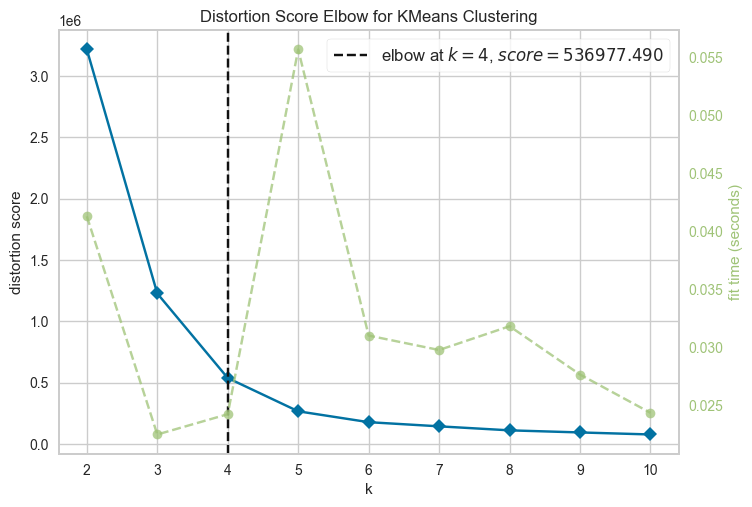

In [ ]:
#Visualize the elbow plot and silhouette plot to choose the number of clusters
elbow_graph = KElbowVisualizer(KMeans(random_state=42), k=10)
elbow_graph.fit(features_labels_data)
elbow_graph.show()
plt.show()

### KMeans search for with silhoutte score

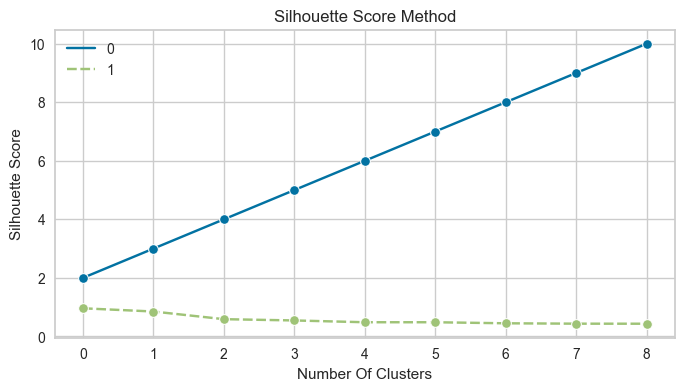

In [ ]:
clusters = [2,3,4,5,6,7,8,9,10] # number of clusters
s_scores = [] # silhouette scores

for n in clusters:
    kmeans = KMeans(n_clusters = n, random_state=43).fit(features_labels_data)
    silhouette = silhouette_score(features_labels_data, kmeans.labels_)
    s_scores.append(silhouette)

plt.figure(figsize=(8,4))
sns.lineplot(data=(clusters, s_scores), marker='o')
plt.title('Silhouette Score Method')
plt.xlabel('Number Of Clusters')
plt.ylabel('Silhouette Score')
plt.show()

### PCA for dimensionality determination

In [ ]:
features_df = features_labels_data.drop(columns=["grade"])
features_df.head()

,#user_prompts,prompt_avg_words,prompt_avg_sentence_length,prompt_avg_chars,#error,#fix,#no,#thank,response_avg_chars,response_avg_words,response_avg_sentence_length,Q_0,Q_1,Q_2,Q_3,Q_4,Q_5,Q_6,Q_7,Q_8
0,14.0,0.322617,0.064877,4.411497,3.0,0.0,1.0,0.0,212.206370,26.255108,1.010375,0.121669,0.240754,0.406415,0.344203,0.442081,0.501032,0.105125,0.082355,0.041075
1,18.0,0.055791,0.055791,0.608325,0.0,0.0,0.0,0.0,113.633582,16.578947,1.384857,0.210707,0.772151,0.740568,0.811677,0.572309,0.973505,0.770091,0.610085,0.463622
2,9.0,0.053652,0.053652,0.524648,3.0,0.0,0.0,1.0,17.187601,3.065649,1.369713,0.085978,0.205666,0.465918,0.270713,0.631067,0.348896,0.350870,0.415376,0.190334
3,20.0,0.017632,0.005965,0.246691,1.0,0.0,1.0,0.0,107.092566,13.347445,0.494491,0.050142,0.096359,0.164982,0.215613,0.385329,0.288037,0.088504,0.223102,0.376481
4,86.0,0.003110,0.003110,0.035971,1.0,2.0,5.0,0.0,18.850913,2.697958,0.224842,0.485869,0.679591,0.762361,0.576194,0.676059,0.831945,0.593740,0.919089,0.393665


In [ ]:
components = range(1, len(features_df[0:-1].columns))
components

range(1, 20)

Explained Variance Ratio For n_components=1 is 92.3945207633637


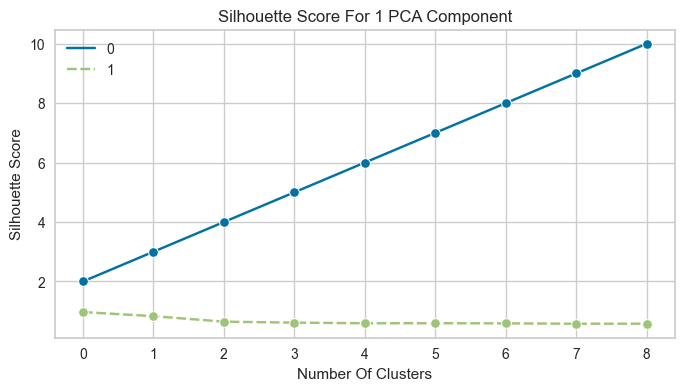

Explained Variance Ratio For n_components=2 is 99.73996416147396


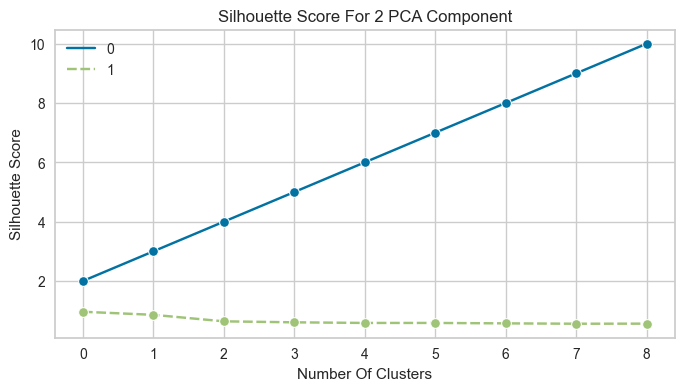

Explained Variance Ratio For n_components=3 is 99.92045915982399


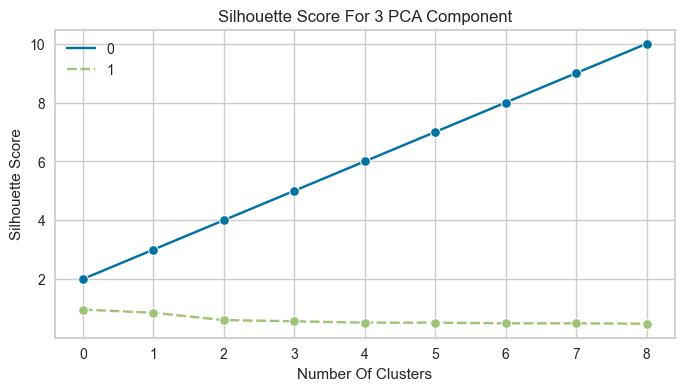

Explained Variance Ratio For n_components=4 is 99.98612336203722


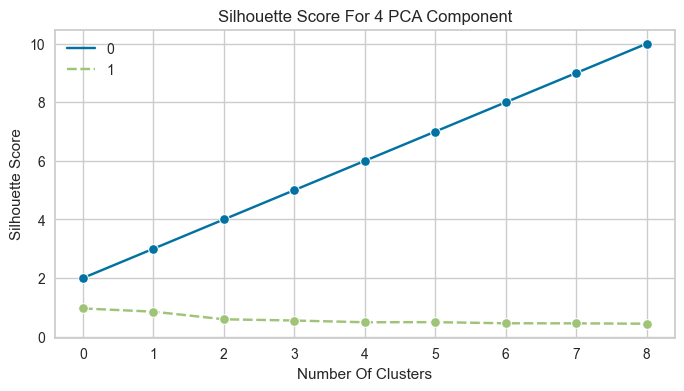

Explained Variance Ratio For n_components=5 is 99.99319323411046


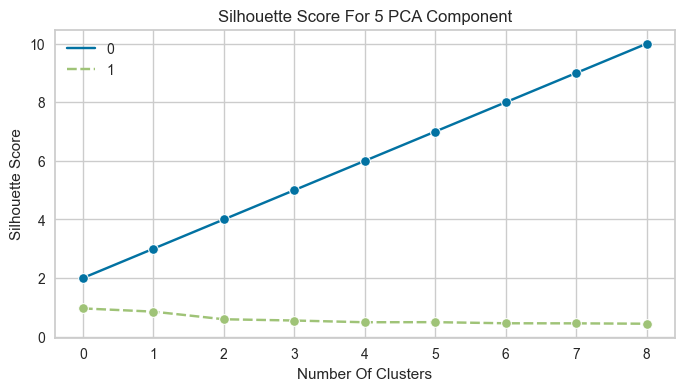

Explained Variance Ratio For n_components=6 is 99.99781452928721


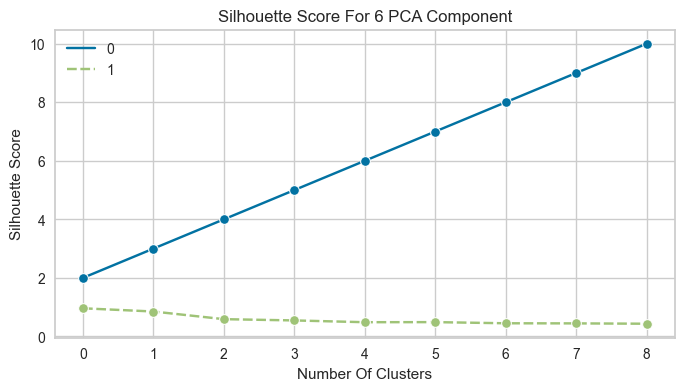

Explained Variance Ratio For n_components=7 is 99.99850531402356


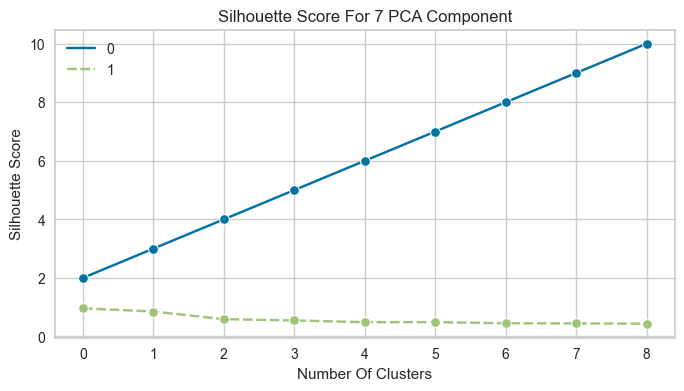

Explained Variance Ratio For n_components=8 is 99.99904827377962


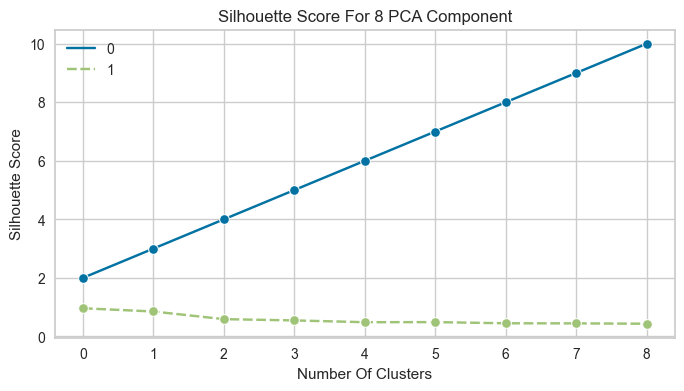

Explained Variance Ratio For n_components=9 is 99.99934085637074


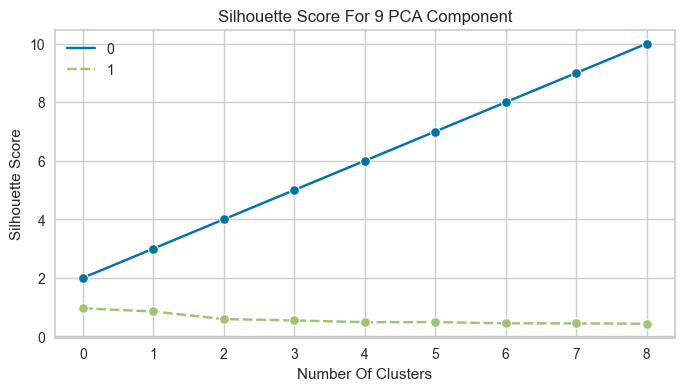

Explained Variance Ratio For n_components=10 is 99.99958835963217


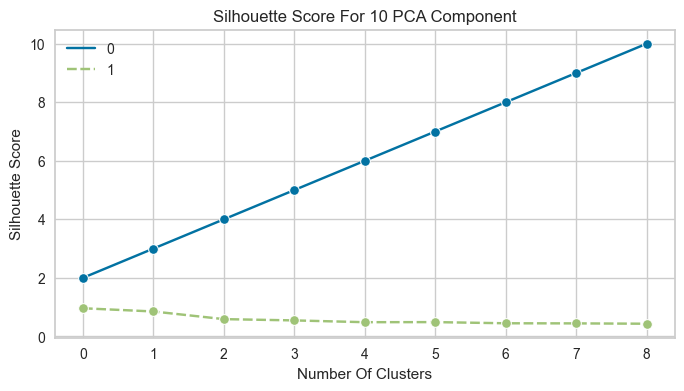

Explained Variance Ratio For n_components=11 is 99.99976717983974


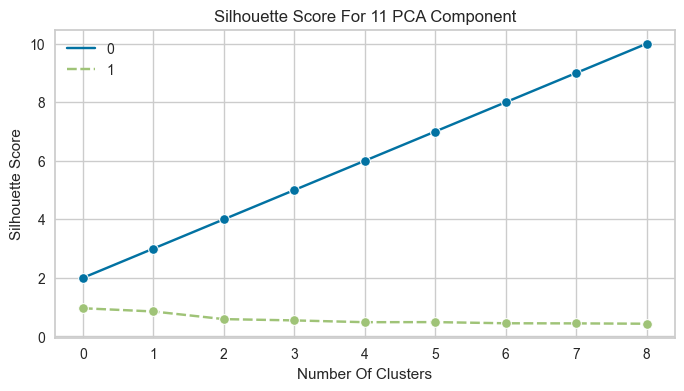

Explained Variance Ratio For n_components=12 is 99.99984823073292


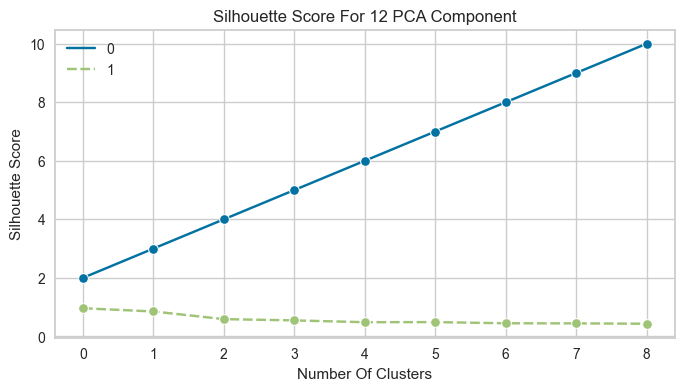

Explained Variance Ratio For n_components=13 is 99.99989750909467


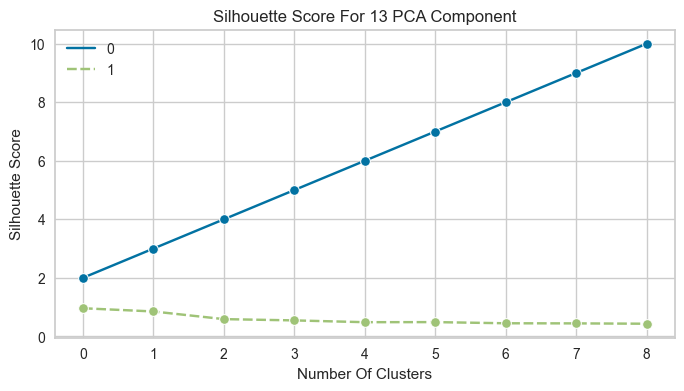

Explained Variance Ratio For n_components=14 is 99.99992616140565


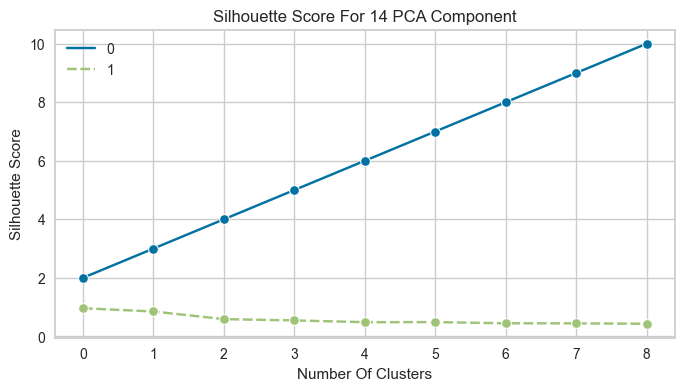

Explained Variance Ratio For n_components=15 is 99.99994400878593


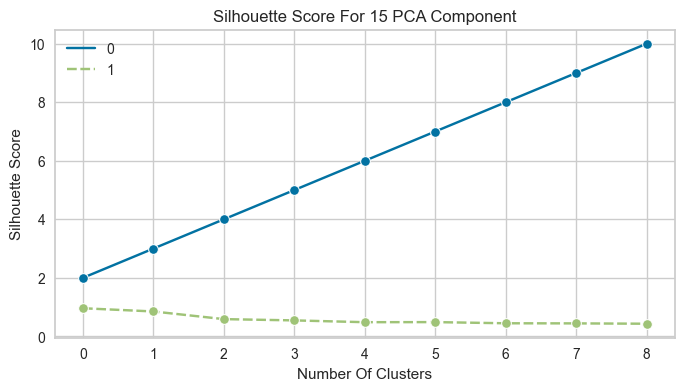

Explained Variance Ratio For n_components=16 is 99.99996020751666


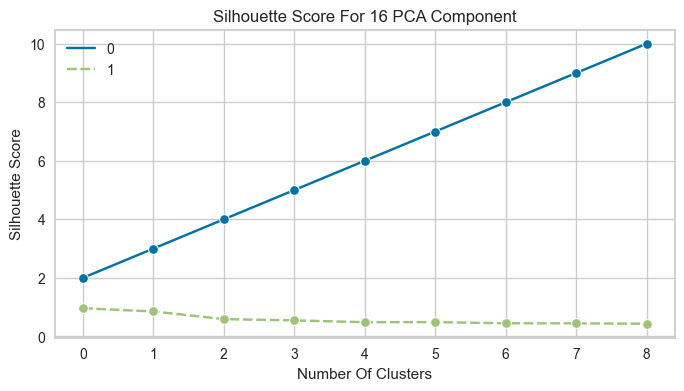

Explained Variance Ratio For n_components=17 is 99.99997335676373


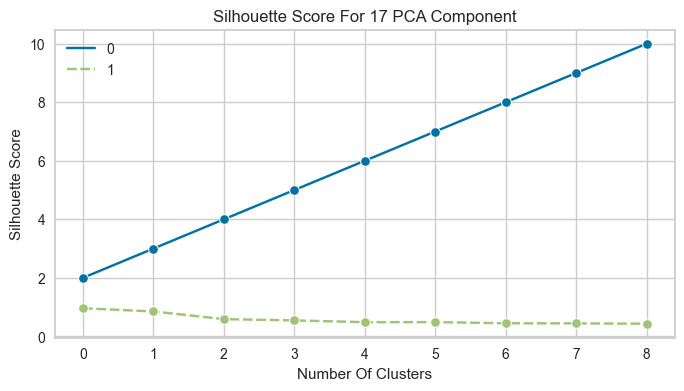

Explained Variance Ratio For n_components=18 is 99.99998338355624


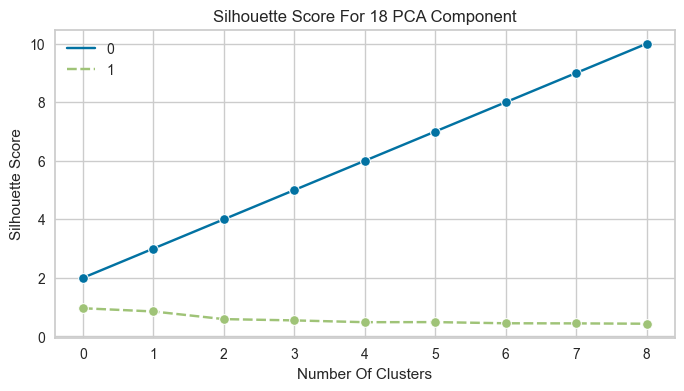

Explained Variance Ratio For n_components=19 is 99.99999188297545


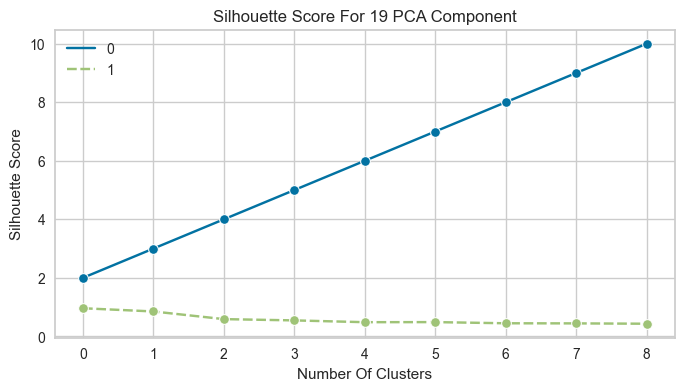

In [ ]:
#With how many n_components we are getting best silhouette score?
for n in components:
    pca = PCA(n_components = n, random_state=42)
    pca.fit(features_labels_data)
    pca_df = pca.transform(features_labels_data)
    print('Explained Variance Ratio For n_components={} is {}'.format(n,pca.explained_variance_ratio_.sum() * 100))

    clusters = [2,3,4,5,6,7,8,9,10] # number of clusters
    s_scores = [] # silhouette scores
    for k in clusters:
        kmeans = KMeans(n_clusters=k, random_state=42).fit(pca_df)
        silhouette = silhouette_score(pca_df, kmeans.labels_)
        s_scores.append(silhouette)

    plt.figure(figsize=(8,4))
    sns.lineplot(data=(clusters, s_scores), marker='o')
    plt.title('Silhouette Score For {} PCA Component'.format(n))
    plt.xlabel('Number Of Clusters')
    plt.ylabel('Silhouette Score')
    plt.show()


In [ ]:
pca = PCA(n_components=15, random_state=42)
pca.fit(features_labels_data)
pca_df = pd.DataFrame(pca.transform(features_labels_data))

In [ ]:
pca_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,30.222308,70.770184,-13.571628,42.464164,-1.671052,0.887134,0.584785,0.711279,0.269508,0.437789,-0.286452,0.161306,0.091286,-0.132446,0.029459
1,-41.785201,2.246856,-10.539799,-7.996286,1.427947,-0.950851,-0.721749,-0.342579,-0.124236,-0.627453,0.268259,-0.189089,0.163041,0.196489,0.024718
2,-108.987608,-67.026499,-26.778926,-0.119055,2.347270,2.659424,-0.373586,-0.081607,0.890576,0.489923,-0.055518,0.357940,0.110758,-0.024278,0.103846
3,-46.814617,-2.698643,-9.183871,-5.699325,-0.896327,-0.328891,-0.181604,0.664445,0.095776,0.372959,-0.815094,0.037975,-0.027703,0.030789,-0.053850
4,-109.380804,-71.733590,50.345817,-1.473434,0.396711,-6.264991,0.375544,2.419490,-1.357222,0.485423,0.768284,0.052788,0.363372,0.239427,0.134566


### KMeans & Model Evaluation

In [ ]:
n_cluster = 4
best_df = pca_df.copy()
best_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,30.222308,70.770184,-13.571628,42.464164,-1.671052,0.887134,0.584785,0.711279,0.269508,0.437789,-0.286452,0.161306,0.091286,-0.132446,0.029459
1,-41.785201,2.246856,-10.539799,-7.996286,1.427947,-0.950851,-0.721749,-0.342579,-0.124236,-0.627453,0.268259,-0.189089,0.163041,0.196489,0.024718
2,-108.987608,-67.026499,-26.778926,-0.119055,2.347270,2.659424,-0.373586,-0.081607,0.890576,0.489923,-0.055518,0.357940,0.110758,-0.024278,0.103846
3,-46.814617,-2.698643,-9.183871,-5.699325,-0.896327,-0.328891,-0.181604,0.664445,0.095776,0.372959,-0.815094,0.037975,-0.027703,0.030789,-0.053850
4,-109.380804,-71.733590,50.345817,-1.473434,0.396711,-6.264991,0.375544,2.419490,-1.357222,0.485423,0.768284,0.052788,0.363372,0.239427,0.134566


In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

# DataFrame'i ölçeklendirme
scaled_data = scaler.fit_transform(best_df)

# Ölçeklendirilmiş verileri yeni bir DataFrame'e dönüştürme
best_df = pd.DataFrame(scaled_data, columns=best_df.columns)

print(best_df)

           0         1         2         3         4         5         6   \
0    0.034106  0.378757  0.148414  0.633557  0.326089  0.338029  0.305525   
1    0.017901  0.317504  0.182484  0.064655  0.400007  0.260256  0.212243   
2    0.002778  0.255580  0.000000  0.153465  0.421934  0.413021  0.237101   
3    0.016769  0.313083  0.197721  0.090552  0.344568  0.286573  0.250808   
4    0.002689  0.251372  0.866673  0.138195  0.375409  0.035393  0.290586   
..        ...       ...       ...       ...       ...       ...       ...   
117  0.020675  0.329087  0.222338  0.136921  0.341433  0.278270  0.266143   
118  0.001093  0.245432  0.690611  0.118772  0.382567  0.086531  0.273203   
119  0.012889  0.296501  0.296234  0.093606  0.342274  0.463141  0.260400   
120  0.031545  0.374421  0.205787  0.051072  0.289192  0.272450  0.279917   
121  0.011166  0.288444  0.299831  0.095097  0.353311  0.541180  0.232853   

           7         8         9         10        11        12        13  

In [ ]:
#train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("Train set size:", len(X_train))
print("Test set size:", len(X_test))

Train set size: 97
Test set size: 25


assign cluster features to data

In [ ]:
best_kmeans = KMeans(n_clusters=4, random_state=42)

In [ ]:
X = best_df.copy()


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("Train set size:", len(X_train))
print("Test set size:", len(X_test))

Train set size: 97
Test set size: 25


In [ ]:
X_train.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
42,0.016023,0.309064,0.195243,0.056705,0.289974,0.249470,0.308394,0.395721,0.278827,0.295293,0.633575,0.430179,0.451990,0.719654,0.493010
105,0.030474,0.368613,0.146879,0.600452,0.311432,0.209924,0.329120,0.421798,0.412776,0.360045,0.396770,0.455742,0.450846,0.232376,0.461018
93,0.023506,0.341018,0.220615,0.102997,0.285770,0.413025,0.309929,0.383854,0.407000,0.228771,0.238905,0.475472,1.000000,0.366657,0.028735
36,0.020760,0.329427,0.216864,0.126566,0.301968,0.453976,0.285633,0.358802,0.294359,0.204245,0.641122,0.383191,0.584052,0.509465,0.520457
100,0.012792,0.296071,0.350456,0.076110,0.350775,0.314562,0.261460,0.289570,0.387688,0.171732,0.274797,0.383288,0.619064,0.667360,0.502228


In [ ]:
y_train.head()

50     100.0
121     51.0
109     96.0
43      94.0
116    100.0
Name: grade, dtype: float64

In [ ]:

# Yeni özellik olarak kümeyi ekleme
X_train['cluster'] = best_kmeans.fit_predict(X_train)
X_test['cluster'] = best_kmeans.fit_predict(X_test)



In [ ]:
X_train.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,cluster
42,0.016023,0.309064,0.195243,0.056705,0.289974,0.249470,0.308394,0.395721,0.278827,0.295293,0.633575,0.430179,0.451990,0.719654,0.493010,0
105,0.030474,0.368613,0.146879,0.600452,0.311432,0.209924,0.329120,0.421798,0.412776,0.360045,0.396770,0.455742,0.450846,0.232376,0.461018,2
93,0.023506,0.341018,0.220615,0.102997,0.285770,0.413025,0.309929,0.383854,0.407000,0.228771,0.238905,0.475472,1.000000,0.366657,0.028735,2
36,0.020760,0.329427,0.216864,0.126566,0.301968,0.453976,0.285633,0.358802,0.294359,0.204245,0.641122,0.383191,0.584052,0.509465,0.520457,0
100,0.012792,0.296071,0.350456,0.076110,0.350775,0.314562,0.261460,0.289570,0.387688,0.171732,0.274797,0.383288,0.619064,0.667360,0.502228,0


In [ ]:
X_test.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,cluster
18,0.017028,0.312497,0.205889,0.102579,0.309237,0.241732,0.314280,0.568775,0.499480,0.230380,0.608490,0.473326,0.975057,0.471724,0.313070,3
45,0.030913,0.369595,0.180289,0.150680,0.321022,0.350792,0.276273,0.609393,0.317177,0.596849,0.262617,0.473796,0.594213,0.647600,0.238678,3
47,0.005303,0.264266,0.438687,0.124910,0.376553,0.528334,0.248137,0.360733,0.117449,0.601790,0.722982,0.362900,0.533117,0.180285,0.568335,1
89,0.010191,0.276295,0.194441,0.195757,0.385972,0.477825,0.220305,0.505325,0.301470,0.281578,0.502728,0.259736,0.633204,0.446349,0.517233,3
4,0.002689,0.251372,0.866673,0.138195,0.375409,0.035393,0.290586,0.886193,0.174612,0.426094,0.619550,0.401187,0.709188,0.644804,0.621682,1


In [ ]:
X_train_2, X_val, y_train_2, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [ ]:
print("Train set size:", len(X_train_2))
print("Validation set size:", len(X_val))

Train set size: 77
Validation set size: 20


### KMeans& XGBRegressor

In [ ]:
# XGBoost modelini başlatma ve eğitme
param_grid = {
    'max_depth': [3, 5, 7],
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'learning_rate': [0.01, 0.1, 0.2],
    'reg_alpha': [0.1, 0.5, 1],  # L1 düzenlileştirme
    'reg_lambda': [0.1, 0.5, 1]  # L2 düzenlileştirme
}
# XGBoost modelini ve GridSearchCV nesnesini başlatma
xgb_model = XGBRegressor()
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error')

# GridSearchCV ile modeli eğitme
grid_search.fit(X_train, y_train)

# En iyi parametrelerle modeli eğitme
best_xgb_model = grid_search.best_estimator_
print("Best params: ", grid_search.best_params_)
eval_set = [(X_val, y_val)]
best_xgb_model.fit(X_train_2, y_train_2, early_stopping_rounds=10, eval_set=eval_set, eval_metric="rmse", verbose=True)

# Test seti üzerinde tahmin yapma
y_train_pred = best_xgb_model.predict(X_train)
y_test_pred = best_xgb_model.predict(X_test)

# Tahmin performansını değerlendirme
print("MSE Train:", mean_squared_error(y_train, y_train_pred))
print("MSE Test:", mean_squared_error(y_test, y_test_pred))
print("R2 Train:", r2_score(y_train, y_train_pred))
print("R2 Test:", r2_score(y_test, y_test_pred))

Best params:  {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'reg_alpha': 0.5, 'reg_lambda': 1}
[0]	validation_0-rmse:82.15717
[1]	validation_0-rmse:73.86811
[2]	validation_0-rmse:66.44193
[3]	validation_0-rmse:59.71824
[4]	validation_0-rmse:53.60896
[5]	validation_0-rmse:48.32043
[6]	validation_0-rmse:43.51052
[7]	validation_0-rmse:39.03459
[8]	validation_0-rmse:35.33851
[9]	validation_0-rmse:31.70487
[10]	validation_0-rmse:28.55783
[11]	validation_0-rmse:25.81322
[12]	validation_0-rmse:23.24369
[13]	validation_0-rmse:21.01864
[14]	validation_0-rmse:19.01115
[15]	validation_0-rmse:17.12369
[16]	validation_0-rmse:15.48807
[17]	validation_0-rmse:13.96961
[18]	validation_0-rmse:12.64362
[19]	validation_0-rmse:11.44483
[20]	validation_0-rmse:10.32392
[21]	validation_0-rmse:9.35026
[22]	validation_0-rmse:8.42149
[23]	validation_0-rmse:7.58490
[24]	validation_0-rmse:6.84820
[25]	validation_0-rmse:6.23828
[26]	validation_0-rmse:5.64360
[27]	validation_0-rmse:5.11485
[28]	validat

/Users/aysenurcerci/Desktop/cs412/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  UserWarning,
/Users/aysenurcerci/Desktop/cs412/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,


[63]	validation_0-rmse:1.56168
[64]	validation_0-rmse:1.56181
[65]	validation_0-rmse:1.56432
[66]	validation_0-rmse:1.56790
[67]	validation_0-rmse:1.56913
[68]	validation_0-rmse:1.57176
[69]	validation_0-rmse:1.57834
MSE Train: 0.6570856558247056
MSE Test: 3.731832372125355
R2 Train: 0.9959791685240881
R2 Test: 0.966758897007406


### KMeans& DecisionTreeRegressor

In [ ]:
# Hiperparametre aralıklarını bir sözlük olarak belirleyin
param_grid = {
    'max_depth': [10, 20, 30, 40, 50, None],  # Ağacın maksimum derinliği
    'min_samples_split': [2, 5, 10, 20, 40],  # Bir düğümü bölmek için gerekli minimum örnek sayısı
    'min_samples_leaf': [1, 2, 4, 8, 16, 32],    # Bir yaprakta olması gereken minimum örnek sayısı
    'criterion': ['squared_error', 'friedman_mse', 'absolute_error']  # Optimizasyon kriteri
}

# Karar ağacı regresör nesnesi oluşturun
regressor = DecisionTreeRegressor(random_state=42)

# GridSearchCV nesnesini oluşturun
grid_search = GridSearchCV(estimator=regressor, param_grid=param_grid,
                           cv=5, n_jobs=-1, verbose=2, scoring='neg_mean_squared_error')

# Grid search'i eğitim veri setine uygula
grid_search.fit(X_train, y_train)

# En iyi parametreleri ve en iyi estimator'ü bul
best_params = grid_search.best_params_

print("Best hyperparameters:", best_params)

Fitting 5 folds for each of 540 candidates, totalling 2700 fits
[CV] END criterion=squared_error, max_depth=10, min_samples_leaf=1, min_samples_split=2; total time=   0.0s
[CV] END criterion=squared_error, max_depth=10, min_samples_leaf=1, min_samples_split=2; total time=   0.0s
[CV] END criterion=squared_error, max_depth=10, min_samples_leaf=1, min_samples_split=2; total time=   0.0s
[CV] END criterion=squared_error, max_depth=10, min_samples_leaf=1, min_samples_split=2; total time=   0.0s
[CV] END criterion=squared_error, max_depth=10, min_samples_leaf=1, min_samples_split=2; total time=   0.0s
[CV] END criterion=squared_error, max_depth=10, min_samples_leaf=1, min_samples_split=5; total time=   0.0s
[CV] END criterion=squared_error, max_depth=10, min_samples_leaf=1, min_samples_split=5; total time=   0.0s
[CV] END criterion=squared_error, max_depth=10, min_samples_leaf=1, min_samples_split=5; total time=   0.0s
[CV] END criterion=squared_error, max_depth=10, min_samples_leaf=1, min_

/Users/aysenurcerci/Desktop/cs412/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/aysenurcerci/Desktop/cs412/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/aysenurcerci/Desktop/cs412/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/aysenurcerci/Desktop/cs412/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. A

[CV] END criterion=squared_error, max_depth=20, min_samples_leaf=4, min_samples_split=2; total time=   0.0s
[CV] END criterion=squared_error, max_depth=20, min_samples_leaf=4, min_samples_split=20; total time=   0.0s
[CV] END criterion=squared_error, max_depth=20, min_samples_leaf=4, min_samples_split=10; total time=   0.0s
[CV] END criterion=squared_error, max_depth=20, min_samples_leaf=4, min_samples_split=40; total time=   0.0s
[CV] END criterion=squared_error, max_depth=20, min_samples_leaf=4, min_samples_split=20; total time=   0.0s
[CV] END criterion=squared_error, max_depth=20, min_samples_leaf=4, min_samples_split=10; total time=   0.0s
[CV] END criterion=squared_error, max_depth=20, min_samples_leaf=4, min_samples_split=40; total time=   0.0s
[CV] END criterion=squared_error, max_depth=20, min_samples_leaf=8, min_samples_split=2; total time=   0.0s
[CV] END criterion=squared_error, max_depth=20, min_samples_leaf=4, min_samples_split=20; total time=   0.0s
[CV] END criterion=sq

with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/aysenurcerci/Desktop/cs412/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/aysenurcerci/Desktop/cs412/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/aysenurcerci/Desktop/cs412/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/aysenurcerci/Desktop/cs412/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only suppor

[CV] END criterion=squared_error, max_depth=None, min_samples_leaf=4, min_samples_split=20; total time=   0.0s
[CV] END criterion=squared_error, max_depth=50, min_samples_leaf=2, min_samples_split=10; total time=   0.0s
[CV] END criterion=squared_error, max_depth=50, min_samples_leaf=32, min_samples_split=2; total time=   0.0s
[CV] END criterion=squared_error, max_depth=50, min_samples_leaf=8, min_samples_split=40; total time=   0.0s
[CV] END criterion=squared_error, max_depth=None, min_samples_leaf=1, min_samples_split=5; total time=   0.0s
[CV] END criterion=squared_error, max_depth=None, min_samples_leaf=2, min_samples_split=10; total time=   0.0s
[CV] END criterion=squared_error, max_depth=50, min_samples_leaf=4, min_samples_split=20; total time=   0.0s
[CV] END criterion=squared_error, max_depth=None, min_samples_leaf=32, min_samples_split=2; total time=   0.0s
[CV] END criterion=squared_error, max_depth=50, min_samples_leaf=32, min_samples_split=5; total time=   0.0s
[CV] END cri

e names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/aysenurcerci/Desktop/cs412/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/aysenurcerci/Desktop/cs412/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/aysenurcerci/Desktop/cs412/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/aysenurcerci/Desktop/cs412/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names onl

0, min_samples_leaf=1, min_samples_split=40; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=10, min_samples_leaf=16, min_samples_split=20; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=10, min_samples_leaf=32, min_samples_split=40; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=10, min_samples_leaf=8, min_samples_split=5; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=10, min_samples_leaf=1, min_samples_split=2; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=10, min_samples_leaf=4, min_samples_split=2; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=20, min_samples_leaf=4, min_samples_split=2; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=20, min_samples_leaf=1, min_samples_split=40; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=10, min_samples_leaf=16, min_samples_split=20; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=10, min_samples_leaf=32, min_s

ll strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/aysenurcerci/Desktop/cs412/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/aysenurcerci/Desktop/cs412/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/aysenurcerci/Desktop/cs412/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/aysenurcerci/Desktop/cs412/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarn

[CV] END criterion=friedman_mse, max_depth=30, min_samples_leaf=4, min_samples_split=20; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=30, min_samples_leaf=2, min_samples_split=10; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=30, min_samples_leaf=1, min_samples_split=10; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=30, min_samples_leaf=32, min_samples_split=2; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=40, min_samples_leaf=16, min_samples_split=2; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=20, min_samples_leaf=16, min_samples_split=5; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=40, min_samples_leaf=2, min_samples_split=10; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=30, min_samples_leaf=1, min_samples_split=10; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=30, min_samples_leaf=32, min_samples_split=5; total time=   0.0s
[CV] END criterion=friedman_

i/Desktop/cs412/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/aysenurcerci/Desktop/cs412/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/aysenurcerci/Desktop/cs412/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/aysenurcerci/Desktop/cs412/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be ra

[CV] END criterion=friedman_mse, max_depth=50, min_samples_leaf=4, min_samples_split=5; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=40, min_samples_leaf=1, min_samples_split=20; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=None, min_samples_leaf=32, min_samples_split=40; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=40, min_samples_leaf=32, min_samples_split=40; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=40, min_samples_leaf=8, min_samples_split=10; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=30, min_samples_leaf=16, min_samples_split=20; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=50, min_samples_leaf=16, min_samples_split=40; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=None, min_samples_leaf=1, min_samples_split=40; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=50, min_samples_leaf=4, min_samples_split=5; total time=   0.0s
[CV] END criterion=fri

/Users/aysenurcerci/Desktop/cs412/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/aysenurcerci/Desktop/cs412/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/aysenurcerci/Desktop/cs412/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/aysenurcerci/Desktop/cs412/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. A

[CV] END criterion=absolute_error, max_depth=30, min_samples_leaf=32, min_samples_split=10; total time=   0.0s
[CV] END criterion=absolute_error, max_depth=10, min_samples_leaf=32, min_samples_split=20; total time=   0.0s
[CV] END criterion=absolute_error, max_depth=30, min_samples_leaf=8, min_samples_split=2; total time=   0.0s
[CV] END criterion=absolute_error, max_depth=10, min_samples_leaf=8, min_samples_split=10; total time=   0.0s
[CV] END criterion=absolute_error, max_depth=40, min_samples_leaf=2, min_samples_split=20; total time=   0.0s
[CV] END criterion=absolute_error, max_depth=20, min_samples_leaf=16, min_samples_split=5; total time=   0.0s
[CV] END criterion=absolute_error, max_depth=30, min_samples_leaf=32, min_samples_split=20; total time=   0.0s
[CV] END criterion=absolute_error, max_depth=10, min_samples_leaf=32, min_samples_split=20; total time=   0.0s
[CV] END criterion=absolute_error, max_depth=30, min_samples_leaf=1, min_samples_split=20; total time=   0.0s
[CV] EN

n error will be raised in 1.2.
  FutureWarning,
/Users/aysenurcerci/Desktop/cs412/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/aysenurcerci/Desktop/cs412/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/aysenurcerci/Desktop/cs412/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/aysenurcerci/Desktop/cs412/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. 

[CV] END criterion=absolute_error, max_depth=50, min_samples_leaf=4, min_samples_split=2; total time=   0.0s
[CV] END criterion=absolute_error, max_depth=50, min_samples_leaf=16, min_samples_split=20; total time=   0.0s
[CV] END criterion=absolute_error, max_depth=50, min_samples_leaf=1, min_samples_split=5; total time=   0.0s
[CV] END criterion=absolute_error, max_depth=50, min_samples_leaf=4, min_samples_split=2; total time=   0.0s
[CV] END criterion=absolute_error, max_depth=50, min_samples_leaf=16, min_samples_split=20; total time=   0.0s
[CV] END criterion=absolute_error, max_depth=50, min_samples_leaf=4, min_samples_split=2; total time=   0.0s
[CV] END criterion=absolute_error, max_depth=50, min_samples_leaf=1, min_samples_split=5; total time=   0.0s
[CV] END criterion=absolute_error, max_depth=50, min_samples_leaf=16, min_samples_split=20; total time=   0.0s
[CV] END criterion=absolute_error, max_depth=50, min_samples_leaf=16, min_samples_split=40; total time=   0.0s
[CV] END cr

/Users/aysenurcerci/Desktop/cs412/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/aysenurcerci/Desktop/cs412/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/aysenurcerci/Desktop/cs412/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/aysenurcerci/Desktop/cs412/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. A

[CV] END criterion=absolute_error, max_depth=None, min_samples_leaf=16, min_samples_split=20; total time=   0.0s
[CV] END criterion=absolute_error, max_depth=None, min_samples_leaf=16, min_samples_split=20; total time=   0.0s
[CV] END criterion=absolute_error, max_depth=None, min_samples_leaf=16, min_samples_split=40; total time=   0.0s
[CV] END criterion=absolute_error, max_depth=None, min_samples_leaf=16, min_samples_split=40; total time=   0.0s
[CV] END criterion=absolute_error, max_depth=None, min_samples_leaf=16, min_samples_split=40; total time=   0.0s
[CV] END criterion=absolute_error, max_depth=None, min_samples_leaf=16, min_samples_split=40; total time=   0.0s
[CV] END criterion=absolute_error, max_depth=None, min_samples_leaf=16, min_samples_split=40; total time=   0.0s
[CV] END criterion=absolute_error, max_depth=None, min_samples_leaf=32, min_samples_split=2; total time=   0.0s
[CV] END criterion=absolute_error, max_depth=None, min_samples_leaf=32, min_samples_split=2; tota

/Users/aysenurcerci/Desktop/cs412/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/aysenurcerci/Desktop/cs412/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/aysenurcerci/Desktop/cs412/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/aysenurcerci/Desktop/cs412/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. A

In [ ]:
best_regressor = grid_search.best_estimator_

In [ ]:
# Prediction
y_train_pred = best_regressor.predict(X_train)
y_test_pred = best_regressor.predict(X_test)

# Calculation of Mean Squared Error (MSE)
print("MSE Train:", mean_squared_error(y_train,y_train_pred))
print("MSE TEST:", mean_squared_error(y_test,y_test_pred))

print("R2 Train:", r2_score(y_train,y_train_pred))
print("R2 TEST:", r2_score(y_test,y_test_pred))

MSE Train: 5.103092783505154
MSE TEST: 29.04
R2 Train: 0.9687732095404462
R2 TEST: 0.7413277085768035


/Users/aysenurcerci/Desktop/cs412/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/aysenurcerci/Desktop/cs412/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


### KMeans& RandomForestRegressor

In [ ]:
# Random Forest Regressor modelini ve GridSearchCV nesnesini başlatm
rf_model = RandomForestRegressor()
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

# GridSearchCV ile modeli eğitme
grid_search_rf = GridSearchCV(estimator=rf_model, param_grid=param_grid_rf, cv=3, scoring='neg_mean_squared_error')

# GridSearchCV ile modeli eğitme
# Not: X_train ve y_train verilerinizi yüklemeniz gerekmektedir.
grid_search_rf.fit(X_train, y_train)

# En iyi parametrelerle modeli eğitme
best_rf_model = grid_search_rf.best_estimator_
best_rf_model.fit(X_train, y_train)

# Test seti üzerinde tahmin yapma
y_train_pred_rf = best_rf_model.predict(X_train)
y_test_pred_rf = best_rf_model.predict(X_test)

# Tahmin performansını değerlendirme
print("MSE Train:", mean_squared_error(y_train, y_train_pred_rf))
print("MSE Test:", mean_squared_error(y_test, y_test_pred_rf))
print("R2 Train:", r2_score(y_train, y_train_pred_rf))
print("R2 Test:", r2_score(y_test, y_test_pred_rf))

/Users/aysenurcerci/Desktop/cs412/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/aysenurcerci/Desktop/cs412/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/aysenurcerci/Desktop/cs412/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/aysenurcerci/Desktop/cs412/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. A

MSE Train: 9.615806417533006
MSE Test: 7.6687903502460815
R2 Train: 0.9411590608208207
R2 Test: 0.9316906483353219


/Users/aysenurcerci/Desktop/cs412/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/aysenurcerci/Desktop/cs412/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
